# Genetic algorithm optimization of a silicon on-chip reflector

**Note: the cost of running the entire notebook is larger than 10 FlexCredits.**

A [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is a search heuristic that mimics the process of natural selection. This algorithm reflects the process of natural evolution where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.

The steps in a GA are typically as follows:

1. **Initial Population**: The process begins with a set of individuals which is called a population. Each individual is a solution to the problem you want to solve.

2. **Fitness Function**: Each individual in the population has a fitness score which indicates how good it is at solving the problem.

3. **Selection**: The algorithm selects individuals, often the fittest among the population, to breed a new generation. The selection can be done in various ways, such as roulette wheel selection, tournament selection, etc.

4. **Crossover**: During crossover, parts of two individuals' chromosome strings are swapped to get a new offspring, which may contain some parts of both parents' strings. This simulates reproduction and biological crossover.

5. **Mutation**: In some new offspring, random genes are mutated or changed to maintain diversity within the population and to avoid premature convergence.

6. **New Generation**: The new generation of population is formed by the offspring. This new generation is then used in the next iteration of the algorithm.

7. **Termination**: The algorithm terminates if the population has converged (does not produce offspring that are significantly different from the previous generation), or a satisfactory solution has been found, or a set number of generations have been produced.

GAs have become a powerful tool for optimizing photonic components, leveraging their ability to efficiently search large and complex design spaces. In photonics, where the performance of components like waveguides, photonic crystals, and fibers can be highly sensitive to geometrical and material parameters, GAs offer a way to find optimal solutions that might be difficult to discover using traditional design methods. 

In this notebook, we demonstrate the optimization of a compact silicon waveguide reflector using GA, utilizing the open source Python library [pyGAD](https://pygad.readthedocs.io/en/latest/). The idea follows `Zejie Yu, Haoran Cui, and Xiankai Sun, "Genetically optimized on-chip wideband ultracompact reflectors and Fabry–Perot cavities," Photon. Res. 5, B15-B19 (2017)` [DOI:10.1364/PRJ.5.000B15](https://doi.org/10.1364/PRJ.5.000B15). The design region of the reflector consists of a grid divided into 18x18 pixels. Each pixel is a square measuring 120 nm by 120 nm. 

<img src="img/optimized_reflector.png" width="450" alt="Schematic of the reflector">

`Tidy3D` is a powerful tool for photonic design optimization due to its fast speed and high throughput. Besides GA, we have demonstrated particle swarm optimizations of a [polarization beam splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/) and a [bullseye cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/), CMA-ES optimization of an [waveguide S-bend](https://www.flexcompute.com/tidy3d/examples/notebooks/SbendCMAES/), and direct binary search optimization of an [optical switch](https://www.flexcompute.com/tidy3d/examples/notebooks/OpticalSwitchDBS/). Furthermore, we also have a growing list of gradient-based adjoint optimization examples including

1. [Mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/),

2. [Waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/),

3. [Metalens](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/),

4. [Waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/), 

5. [Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin9WDM/),

6. [Y-branch](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin10YBranchLevelSet/),

7. [MZI circuit](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin11CircuitMZI/),

8. [Light extractor](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin12LightExtractor/).

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

For simplicity, we will use the silicon and oxide media directly from the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html#).

In [2]:
Si = td.material_library["cSi"]["Palik_Lossless"]
SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

The simulation wavelength range is 1450 nm to 1650 nm.

In [3]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.65, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

The waveguide has a 500 nm width and 220 nm thickness. The design region consists of 18 by 18 pixels. Each pixel is 120 nm by 120 nm. Due to the symmetry, we only consider symmetric design so the total number of tunable pixels is 18*9=162.

In [4]:
w = 0.5  # width of the waveguide
t = 0.22  # thickness of the silicon
l = 1  # length of the waveguide in the simulation
Px = Py = 0.12  # pixel sizes in the x and y directions
Nx = 18  # number of pixels in the x direction
Ny = 9  # numbre of pixels in the y direction
buffer = 0.8  # buffer spacing

We will an array of length 162 to represent a design. Each element corresponds to each pixel in the design region. An element value of 1 means the pixel is silicon while an element value of 0 means the pixel is void. To facilitate the optimization, we define a helper function `create_design(pixels)` that takes the pixel array and creates the [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) of the simulation, inlcuding the waveguide and the design region. 

In [5]:
def create_design(pixels):
    geo = 0
    for i, pixel in enumerate(pixels):
        if pixel == 1:
            geo += td.Box(
                center=(l + Px / 2 + Px * (i % Nx), Py * Ny - Py / 2 - Py * (i // Nx), t / 2),
                size=(Px, Py, t),
            )
            geo += td.Box(
                center=(l + Px / 2 + Px * (i % Nx), -(Py * Ny - Py / 2 - Py * (i // Nx)), t / 2),
                size=(Px, Py, t),
            )
    geo = geo + td.Box(center=(0, 0, t / 2), size=(2 * l, w, t))

    design = td.Structure(geometry=geo, medium=Si)

    return design

As a quick check, we create a random array and plot the created structures.

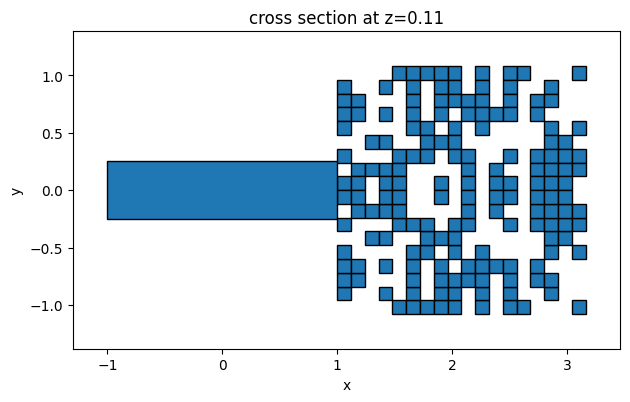

In [6]:
pixels = np.random.choice([0, 1], size=Nx * Ny)
design = create_design(pixels)
design.plot(z=t / 2)
plt.show()

Furthermore, we define a `make_sim(pixels)` function to define the entire simulation given the pixel array. The simulation includes a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to launch the TE0 mode at the waveguide and a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) next to the source to measure the reflection. To minimize data download during the optimization, we will only record the reflection at the central wavelength of 1550 nm since the objective is to maximize this value. 

In [8]:
def make_sim(pixels):

    design = create_design(pixels)

    # add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
    mode_source = td.ModeSource(
        center=(l / 2, 0, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # add a mode monitor to measure transmission at the output waveguide
    mode_monitor = td.ModeMonitor(
        center=(l / 4, 0, t / 2),
        size=mode_source.size,
        freqs=[freq0],
        mode_spec=mode_spec,
        name="mode",
    )

    # define simulation domain size
    Lx = l + Nx * Px + buffer
    Ly = 2 * Ny * Py + 2 * buffer
    Lz = 10 * t

    eff_inf = 1e2  # effective infinity

    # define substrate structure
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, 0)
        ),
        medium=SiO2,
    )

    run_time = 5e-13  # simulation run time

    # simulation box
    sim_box = td.Box.from_bounds(rmin=(0, -Ly / 2, -Lz / 2), rmax=(Lx, Ly / 2, Lz / 2))

    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=16, wavelength=lda0),
        structures=[design, substrate],
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, -1, 0),
    )

    return sim

Again, we test it by defining a simulation with a random pixel array. From the 3D view, we confirm that the simulation setup is correct.

In [9]:
sim = make_sim(pixels)
sim.plot_3d()

## Fitness Function

An important step in any optimization is to define the objective function, which is often called the fitness function in the context of GA. Here we define the fitness function according to the convention in [pyGAD](https://pygad.readthedocs.io/en/latest/). By default, the evaluation of the fitness function in each generation of the GA is done sequentially. To harness the concurrent run in Tidy3D, we will submit all simulations in each generation as a batch. In `fitness_function`, the argument `pixels_array` is a 2D array, where each row is a pixel array of size 162. The number of columns is the number of solutions in the population, which we will define later. 

In addition, we define the `on_generation` function, which is called after each generation, to provide a real time update on the optimization. 

In [10]:
def fitness_function(ga_instance, pixels_array, solution_indices):
    sims = {}
    R = []

    # define all simulations in the generation
    for i in range(pixels_array.shape[0]):
        pixels = pixels_array[i]
        sim = make_sim(pixels)
        sims[f"sim_{i}"] = sim

    # define and submit a batch
    batch = web.Batch(simulations=sims, verbose=False)
    batch_results = batch.run(path_dir="data")

    # extract reflection results from all simulations
    for i in range(pixels_array.shape[0]):
        sim_data = batch_results[f"sim_{i}"]
        R.append(abs(sim_data["mode"].amps.sel(direction="-").squeeze(drop=True).values) ** 2)
    return R


# function to be called in each generation
def on_generation(ga_instance):
    best_fitness = ga_instance.best_solution(ga_instance.last_generation_fitness)[1]
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {best_fitness:.3f}")

## GA Optimizer

Now we are ready to create a GA optimizer. First we need to define some hyper-parameters. In this particular example, we will use 30 solutions per population and run the optimization for a total of 25 generations. There are a number of parameters we can tune to change the selection, crossover, and mutation processes. We only change a few and leave the most to the default settings. Users are encouraged to explore these settings and fine tune them for better results. For reproducibility, we also set a fixed random seed.

In [11]:
sol_per_pop = 30  # number of solutions in the population
num_generations = 25  # number of generation

num_parents_mating = 10  # number of mating parents
parent_selection_type = "sss"  # parent selection rule

crossover_type = "single_point"  # crossover rule
crossover_probability = 0.7  # cross over probability

mutation_type = "inversion"  # mutation rule

# define the optimizer
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    parent_selection_type=parent_selection_type,
    mutation_type=mutation_type,
    crossover_type=crossover_type,
    crossover_probability=crossover_probability,
    sol_per_pop=sol_per_pop,
    num_genes=Nx * Ny,
    init_range_low=0,
    init_range_high=2,
    gene_type=int,
    fitness_batch_size=sol_per_pop,
    on_generation=on_generation,
    random_seed=1,
)

/home/momchil/miniconda3/envs/tidy3d-test/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


## Optimization and Results

With the optimizer defined, we are ready to start the optimization. With the defined `on_generation` function, we will print out the best fitness in each generation. We should see a steady increase of the fitness function as the population evolves.

In [12]:
ga_instance.run()

Generation 1: Best Fitness = 0.590
Generation 2: Best Fitness = 0.634
Generation 3: Best Fitness = 0.695
Generation 4: Best Fitness = 0.752
Generation 5: Best Fitness = 0.831
Generation 6: Best Fitness = 0.831
Generation 7: Best Fitness = 0.866
Generation 8: Best Fitness = 0.866
Generation 9: Best Fitness = 0.889
Generation 10: Best Fitness = 0.895
Generation 11: Best Fitness = 0.895
Generation 12: Best Fitness = 0.895
Generation 13: Best Fitness = 0.895
Generation 14: Best Fitness = 0.895
Generation 15: Best Fitness = 0.919
Generation 16: Best Fitness = 0.919
Generation 17: Best Fitness = 0.919
Generation 18: Best Fitness = 0.919
Generation 19: Best Fitness = 0.919
Generation 20: Best Fitness = 0.919
Generation 21: Best Fitness = 0.919
Generation 22: Best Fitness = 0.919
Generation 23: Best Fitness = 0.919
Generation 24: Best Fitness = 0.919
Generation 25: Best Fitness = 0.919


Generation 5: Best Fitness = 0.676


Generation 6: Best Fitness = 0.729


Generation 7: Best Fitness = 0.729


Generation 8: Best Fitness = 0.778


Generation 9: Best Fitness = 0.778


Generation 10: Best Fitness = 0.788


Generation 11: Best Fitness = 0.788


Generation 12: Best Fitness = 0.788


Generation 13: Best Fitness = 0.788


Generation 14: Best Fitness = 0.788


Generation 15: Best Fitness = 0.788


KeyboardInterrupt: 

After the optimization is complete, we see that we achieved the best fitness (reflection) of 0.928. We can plot the best fitness as a function of generation to better visualize the improvement. 

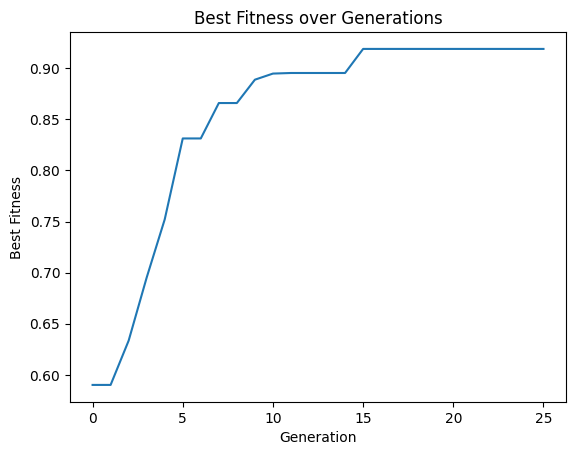

Fitness value of the best solution = 0.919


In [13]:
# Plotting the best fitness over generations
best_fitness = ga_instance.best_solutions_fitness
generations = range(len(best_fitness))

plt.plot(generations, best_fitness)
plt.title("Best Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.show()

pixels_final, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness:.3f}")

Now that we have an optimized design, we will grab the best pixel array and re-simulate the design with a broadband [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) and a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) at the central wavelength. This final simulation can be defined by copying the original simulation and updating the monitors.

In [14]:
sim_final = make_sim(pixels_final)

# update mode monitor's recording frequencies
mode_monitor = sim.monitors[0].copy(update={"freqs": freqs})

# add a field monitor to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# update simulation to use the new monitors
sim_final = sim_final.copy(update={"monitors": [mode_monitor, field_monitor]})

# submit the simulation to the server
sim_data_final = web.run(simulation=sim_final, task_name="final design")

14:37:59 CEST Created task 'final design' with task_id                          
              'fdve-c1d3ed53-4fab-4d39-898d-03725212ee60' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=543562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=13105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\taskId]8;;\]8;id=543562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\=]8;;\]8;id=403780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\fdve]8;;\]8;id=543562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\-c1d3ed53-4f]8;;\
              ]8;id=543562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\ab-4d39-898d-03725212ee60']8;;\.

Output()

14:38:01 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

14:38:48 CEST status = preprocess

14:38:51 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

14:39:01 CEST early shutoff detected at 36%, exiting.

              status = postprocess

Output()

14:39:03 CEST status = success

14:39:04 CEST View simulation result at                                         
              ]8;id=995813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=2340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\taskId]8;;\]8;id=995813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\=]8;;\]8;id=865616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\fdve]8;;\]8;id=995813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\-c1d3ed53-4f]8;;\
              ]8;id=995813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1d3ed53-4fab-4d39-898d-03725212ee60\ab-4d39-898d-03725212ee60']8;;\.

Output()

14:39:06 CEST loading simulation from simulation_data.hdf5

After the simulation, we visualize the electric field norm at the central wavelength. As expected, a strong reflection is observed. 

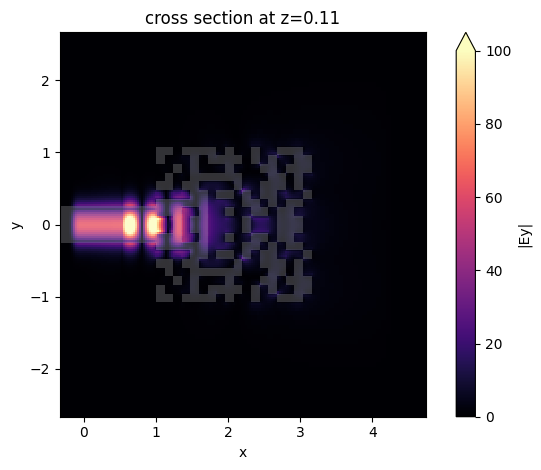

In [15]:
sim_data_final.plot_field("field", "Ey", "abs", vmin=0, vmax=1e2)
plt.show()

Finally plot the reflection spectrum, where we see a broadband reflection. Considering the very compact footprint, the performance is very good. With this reflector design, we can further construct other devices such as high-quality-factor Fabry–Perot cavities as demonstrated in the [publication](https://doi.org/10.1364/PRJ.5.000B15).

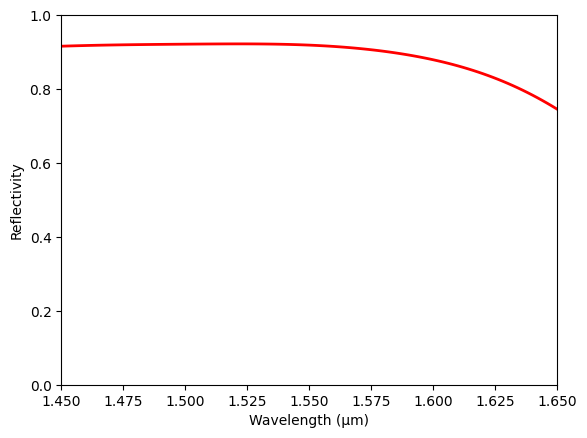

In [16]:
R = abs(sim_data_final["mode"].amps.sel(direction="-").squeeze(drop=True).values) ** 2

plt.plot(ldas, R, "red", linewidth=2)
plt.xlim(min(ldas), max(ldas))
plt.ylim(0, 1)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectivity")
plt.show()

With the optimized design, we can directly export a GDS file of the reflector for fabrication. 

In [16]:
# make the misc/ directory to store the GDS file if it doesnt exist already
import os
if not os.path.exists('./misc/'):
    os.mkdir('./misc/')
    
sim_final.to_gds_file(fname="misc/optimized_reflector.gds", z=t / 2)